Notebook: Estudo da variação do hop para sinais sem ruído

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal.windows import hann
from matplotlib import gridspec
import json

In [2]:
import utils
import functions_for_param_study as funcstud

Aquisição dos sinais simulados e geração dos espectrogramas:

In [3]:
qntty = 100
test_not_save = True

In [4]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(100, 2048, 2)
(100, 2048)
(100, 2048)


In [5]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a

In [6]:
corrupted_fids = utils.create_corrupted_fids(gt=gt_fids,t=t,std_base=6,std_var=2,ntransients=160)

In [7]:
mfft_ = 512
window_ = hann(mfft_,sym=True)
hop_ = np.arange(2,128,2).astype('int')
norm_ = 'abs'
spgram_hop_gt = {}
spgram_hop_ns = {}
for i in range(hop_.shape[0]):
    spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_,mfft=mfft_,hop=int(hop_[i]),norm=norm_,correct_time=True,a=a,b=b)
    spgram_hop_gt['hop_'+str(hop_[i])] = [spgram_gt, freq_spect, ppm_spect, t_spect]
    spgram_ns, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=np.mean(corrupted_fids[:,:,1,:]-corrupted_fids[:,:,0,:],axis=2),bandwidth=bandwidth,window=window_,mfft=mfft_,hop=int(hop_[i]),norm=norm_,correct_time=True,a=a,b=b)
    spgram_hop_ns['hop_'+str(hop_[i])] = [spgram_ns, freq_spect, ppm_spect, t_spect]

In [8]:
gt_metrics = utils.read_txt_file_wth_qnttive_metrics('quantitative_metrics_no_noise_hop_variation_mfft_512.txt')
ns_metrics = utils.read_txt_file_wth_qnttive_metrics('quantitative_metrics_with_noise_hop_variation_mfft_512.txt')

In [9]:
metrics_names = list(gt_metrics.keys())

Perda da resolução temporal: o número de colunas cai consideravelmente conforme o hop aumenta.

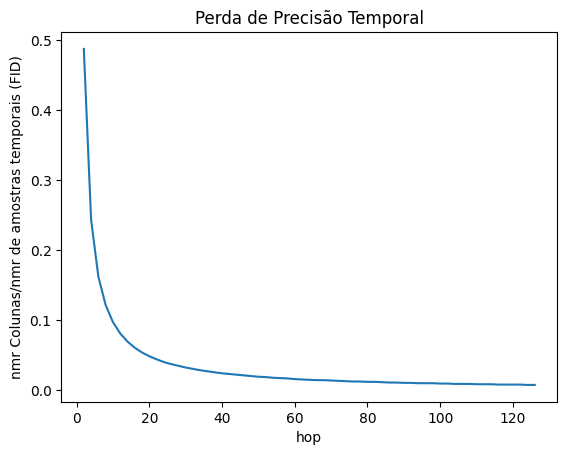

In [10]:
info_concentration = []
for i in range(len(hop_)):
    info_concentration.append(spgram_hop_gt['hop_'+str(hop_[i])][0].shape[2]/gt_fids.shape[1])

plt.plot(hop_,info_concentration)
plt.ylabel('nmr Colunas/nmr de amostras temporais (FID)')
plt.xlabel('hop')
plt.title('Perda de Precisão Temporal')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_loss_time_precision.png')

Observação visual: 

Imagens sem ruído: Notam-se mudanças nas listras dos picos e na quantidade dos picos "fantasmas".

Imagens com ruído: O mesmo pode ser dito das litras, mas ao invés de mudar os picos fantasmas muda a quantidadede ondulações com o ruído, essas faixas de ondulação parecem mais frequentes, de forma que olhando todas as imagens com a mesma largura, o padrão formado pelo ruído parece mudar.

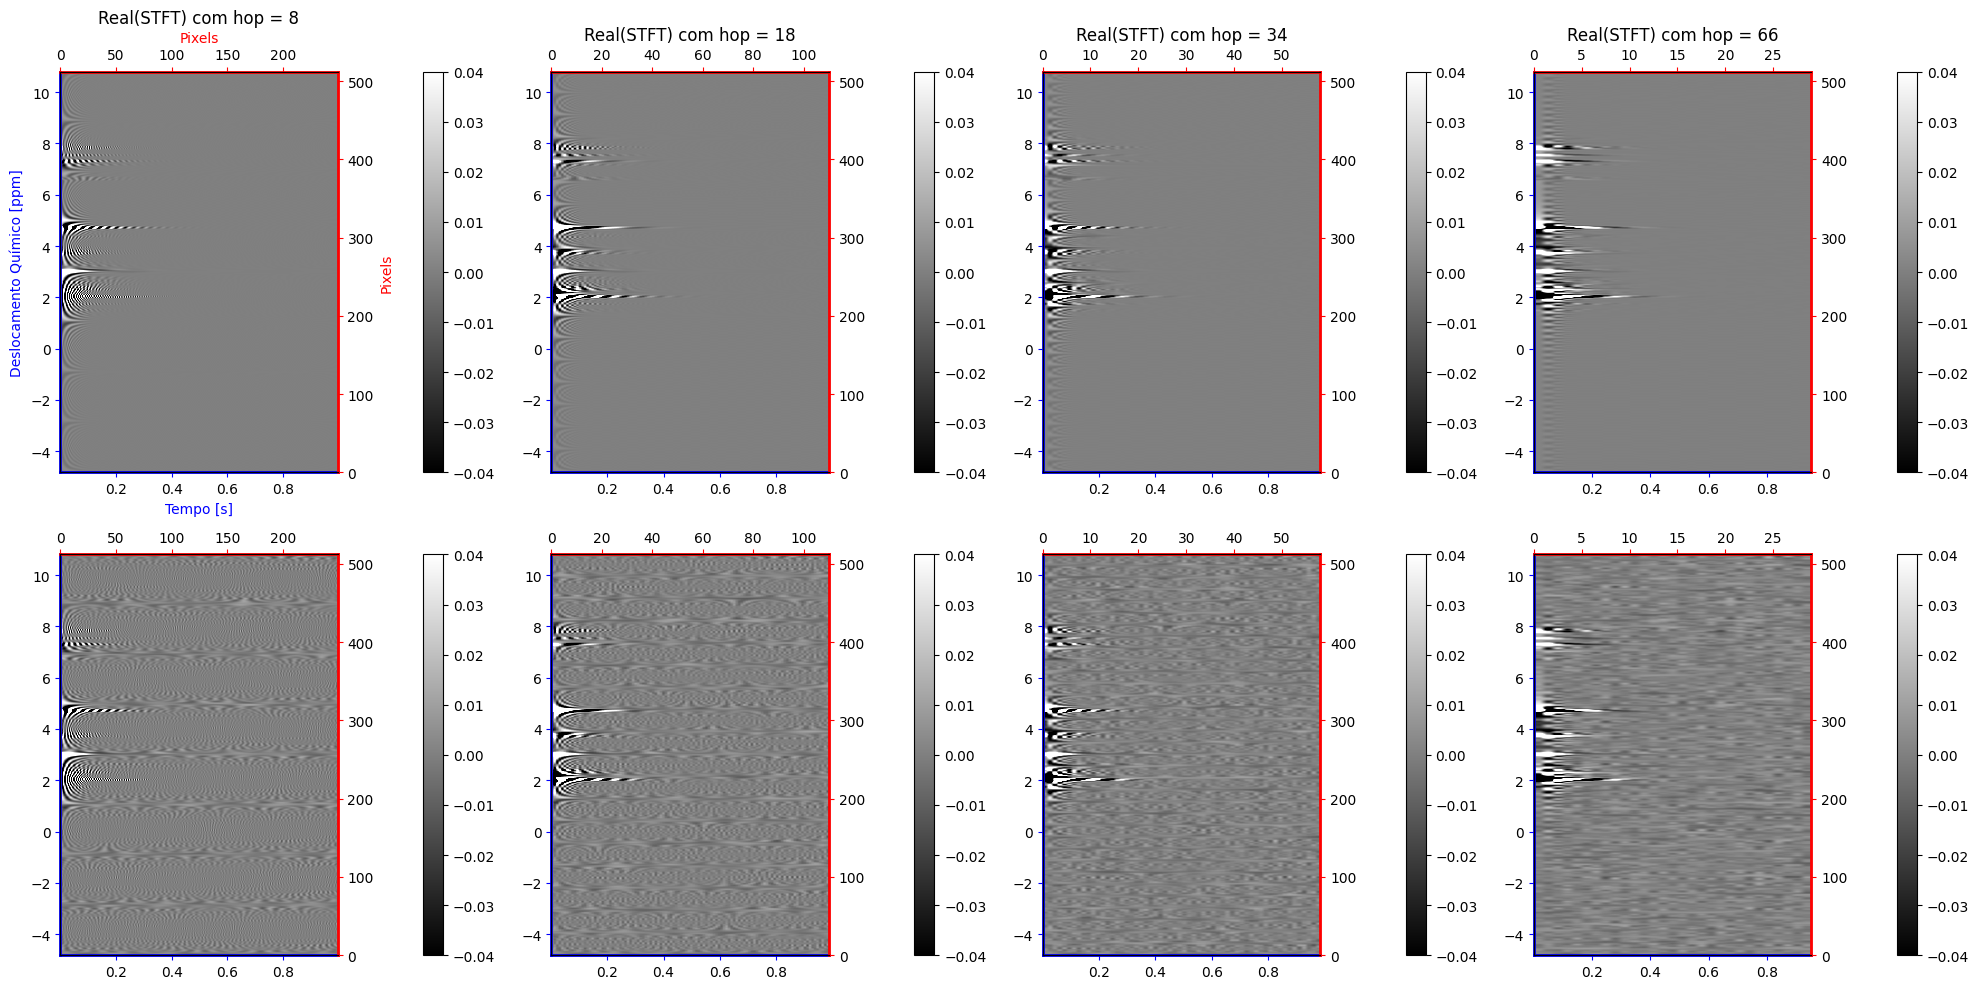

In [11]:
fig,ax = plt.subplots(2,4,figsize=(20,10))
im = ax.flat[0].imshow(np.real(spgram_hop_gt['hop_'+str(hop_[3])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[3])][-1][0],spgram_hop_gt['hop_'+str(hop_[3])][-1][-1],spgram_hop_gt['hop_'+str(hop_[3])][2][-1],spgram_hop_gt['hop_'+str(hop_[3])][2][0]))
im = ax.flat[1].imshow(np.real(spgram_hop_gt['hop_'+str(hop_[8])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[8])][-1][0],spgram_hop_gt['hop_'+str(hop_[8])][-1][-1],spgram_hop_gt['hop_'+str(hop_[8])][2][-1],spgram_hop_gt['hop_'+str(hop_[8])][2][0]))
im = ax.flat[2].imshow(np.real(spgram_hop_gt['hop_'+str(hop_[16])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[16])][-1][0],spgram_hop_gt['hop_'+str(hop_[16])][-1][-1],spgram_hop_gt['hop_'+str(hop_[16])][2][-1],spgram_hop_gt['hop_'+str(hop_[16])][2][0]))
im = ax.flat[3].imshow(np.real(spgram_hop_gt['hop_'+str(hop_[32])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[32])][-1][0],spgram_hop_gt['hop_'+str(hop_[32])][-1][-1],spgram_hop_gt['hop_'+str(hop_[32])][2][-1],spgram_hop_gt['hop_'+str(hop_[32])][2][0]))
im =ax.flat[4].imshow(np.real(spgram_hop_ns['hop_'+str(hop_[3])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[3])][-1][0],spgram_hop_gt['hop_'+str(hop_[3])][-1][-1],spgram_hop_gt['hop_'+str(hop_[3])][2][-1],spgram_hop_gt['hop_'+str(hop_[3])][2][0]))
im =ax.flat[5].imshow(np.real(spgram_hop_ns['hop_'+str(hop_[8])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[8])][-1][0],spgram_hop_gt['hop_'+str(hop_[8])][-1][-1],spgram_hop_gt['hop_'+str(hop_[8])][2][-1],spgram_hop_gt['hop_'+str(hop_[8])][2][0]))
im = ax.flat[6].imshow(np.real(spgram_hop_ns['hop_'+str(hop_[16])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[16])][-1][0],spgram_hop_gt['hop_'+str(hop_[16])][-1][-1],spgram_hop_gt['hop_'+str(hop_[16])][2][-1],spgram_hop_gt['hop_'+str(hop_[16])][2][0]))
im = ax.flat[7].imshow(np.real(spgram_hop_ns['hop_'+str(hop_[32])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_gt['hop_'+str(hop_[32])][-1][0],spgram_hop_gt['hop_'+str(hop_[32])][-1][-1],spgram_hop_gt['hop_'+str(hop_[32])][2][-1],spgram_hop_gt['hop_'+str(hop_[32])][2][0]))

hop_plot = [3,8,16,32,3,8,16,32]
for i in range(2):
    for j in range(4):
        fig.colorbar(im, ax=ax[i,j], pad = 0.2)
for i in range(8):
    par1 = ax.flat[i].twiny()  # Additional x-axis
    par2 = ax.flat[i].twinx()  # Additional y-axis
    if i < 4:
        ax.flat[i].set_title('Real(STFT) com hop = '+str(hop_[hop_plot[i]]))
    if  i == 0:
        ax.flat[i].set_xlabel('Tempo [s]')
        ax.flat[i].set_ylabel('Deslocamento Químico [ppm]')
        ax.flat[i].xaxis.label.set_color('b')
        ax.flat[i].yaxis.label.set_color('b')
    ax.flat[i].spines['left'].set_visible(True)
    ax.flat[i].spines['bottom'].set_visible(True)
    ax.flat[i].spines['left'].set_color('b')
    ax.flat[i].spines['bottom'].set_color('b')
    ax.flat[i].spines['left'].set_linewidth(2)
    ax.flat[i].spines['bottom'].set_linewidth(2)
    # Set the position of the additional axes
    par1.spines['top'].set_position(('axes', 1))
    par2.spines['right'].set_position(('axes', 1))
    # Customize the additional axes
    par1.set_xlim(0,spgram_hop_gt['hop_'+str(hop_[hop_plot[i]])][0].shape[2])
    par2.set_ylim(0,spgram_hop_gt['hop_'+str(hop_[hop_plot[i]])][0].shape[1])
    if i == 0:
        par1.set_xlabel("Pixels")
        par2.set_ylabel("Pixels")
        par1.xaxis.label.set_color('r')
        par2.yaxis.label.set_color('r')
    # Turn off unwanted spines for clarity
    par1.spines['top'].set_visible(True)
    par2.spines['right'].set_visible(True)
    par2.spines['right'].set_color('r')
    par1.spines['top'].set_color('r')
    par2.spines['right'].set_linewidth(2)
    par1.spines['top'].set_linewidth(2)
    # Synchronize the tick positions of the host and the twin axes
    ax.flat[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False,color='b')
    par1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True,color ='r')
    ax.flat[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False,color='b')
    par2.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True,color='r')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_image_examples.png')

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [12]:
list_of_t_spects = []
list_of_ppm_spects = []
for i in range(hop_.shape[0]):
    list_of_t_spects.append(spgram_hop_gt['hop_'+str(hop_[i])][-1])
    list_of_ppm_spects.append(spgram_hop_gt['hop_'+str(hop_[i])][2])
idx_time_0d05 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.05)
idx_time_0d4 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.4)
idx_time_0d6 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.6)
idx_freq_0ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=0)
idx_freq_1ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1)
idx_freq_4ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4)
idx_freq_8ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8)
idx_freq_8d5ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8.5)
idx_freq_NAA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.02)
idx_freq_GABA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.00)
idx_freq_Glx = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.75)

Espectrogramas concatenados:

Olhando mais de perto, fica visível que existe realmente uma diferença na quantidade e formato das listras de cada imagem. A questão dos picos fantasmas e faixas de ruído também é visível quando se olha a parte real do espectrograma. O pico de GABA parece se manter sempre branco com um envoltório preto. A base dos picos é interconectada, i.e., é difícil delimitar a região de cada pico. Com o aumento do hop e a mudança da frequência dos picos menos significativos (fantasmas e faixas de ruído), tem-se a impressão que cada pico está associado a um bloco de frequências cuja extensão parece diminuir com o aumento do hop. Essa impressão fica ainda mais acentuada quando observa-se o valor absoluto da parte real do espectrograma, onde, devido ao nível de contraste utilizado, nota-se linhas pretas separando tais blocos de frequência (em branco). Tais modificações sugerem mudanças na resolução frequencial da imagem. Devido aos diferentes padrões de listras de cada imagem é difícil visualmente concluir se existe um impacto na resolução frequencial dos picos relevante, i.e., que trazem informações sobre a composição química da região cerebral amostrada. 

In [13]:
aux_concat = (np.arange(4,len(hop_),6)).tolist()
spgram_hop_concat_gt = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_gt,list_time_idx=idx_time_0d4,fid_idx_plot=0)
spgram_hop_concat_ns = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_ns,list_time_idx=idx_time_0d4,fid_idx_plot=0)

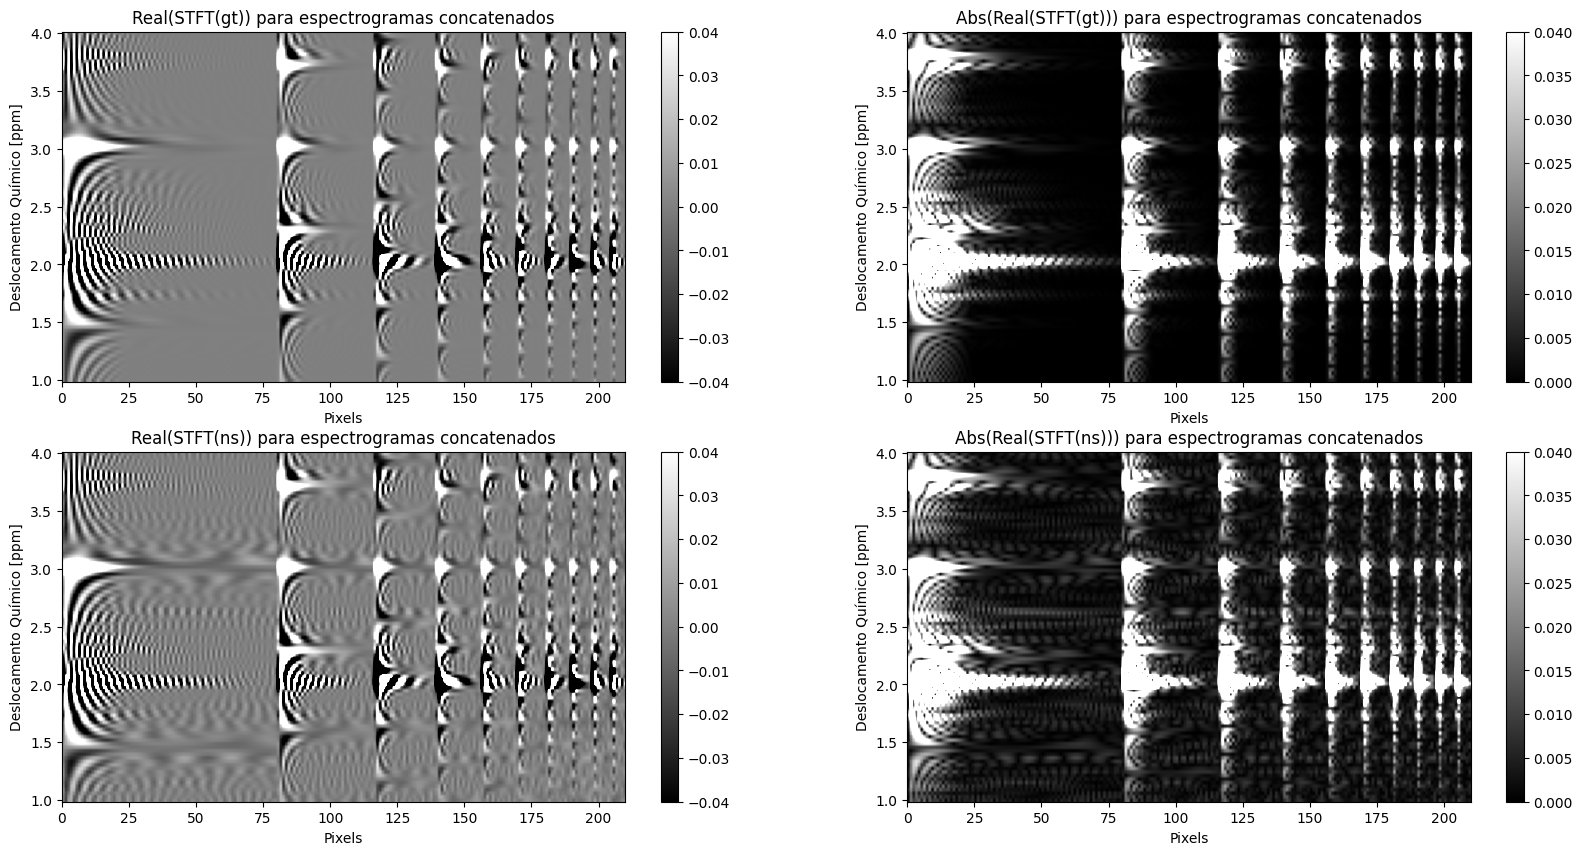

In [14]:
fig,ax = plt.subplots(2,2,figsize=(20,10))
im = ax[0,0].imshow(np.real(spgram_hop_concat_gt[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_gt.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Real(STFT(gt)) para espectrogramas concatenados')
im = ax[0,1].imshow(np.abs(np.real(spgram_hop_concat_gt[idx_freq_1ppm[0]:idx_freq_4ppm[0],:])), origin='lower', aspect='auto',cmap='gray',vmin=0,vmax=0.04,
          extent = (0,spgram_hop_concat_gt.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Abs(Real(STFT(gt))) para espectrogramas concatenados')
im = ax[1,0].imshow(np.real(spgram_hop_concat_ns[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_ns.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
fig.colorbar(im, ax=ax[1,0])
ax[1,0].set_title('Real(STFT(ns)) para espectrogramas concatenados')
im = ax[1,1].imshow(np.abs(np.real(spgram_hop_concat_ns[idx_freq_1ppm[0]:idx_freq_4ppm[0],:])), origin='lower', aspect='auto',cmap='gray',vmin=0,vmax=0.04,
          extent = (0,spgram_hop_concat_ns.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
fig.colorbar(im, ax=ax[1,1])
ax[1,1].set_title('Abs(Real(STFT(ns))) para espectrogramas concatenados')
for i in range(4):
    ax.flat[i].set_xlabel('Pixels')
    ax.flat[i].set_ylabel('Deslocamento Químico [ppm]')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_concatenated_image.png')

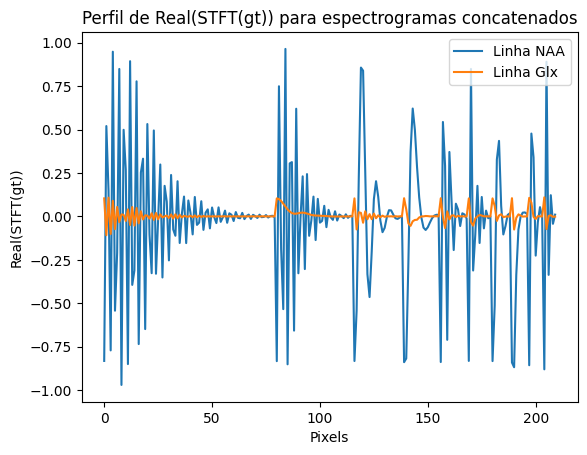

In [15]:
plt.plot(np.real(spgram_hop_concat_gt[idx_freq_NAA[0],:]),label='Linha NAA')
plt.plot(np.real(spgram_hop_concat_gt[idx_freq_Glx[0],:]),label='Linha Glx')
plt.xlabel('Pixels')
plt.ylabel('Real(STFT(gt))')
plt.title('Perfil de Real(STFT(gt)) para espectrogramas concatenados')
plt.legend(loc='upper right')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_concatenated_profile.png')

Projeção no eixo da frequência:

In [16]:
plot_id = [0,29,43,50,59]
list_projections_abs_gt = []
list_projections_real_gt = []
list_projections_abs_ns = []
list_projections_real_ns = []
idx_fwhm_gt = {}
idx_fwhm_real_gt = {}
idx_fwhm_ns = {}
idx_fwhm_real_ns = {}
list_of_ppm_spects = []
idx_freq_NAA_aux = []
idx_freq_GABA_aux = []
idx_freq_Glx_aux = []
for i in range(len(plot_id)):
    list_projections_abs_gt.append(np.sum(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])), axis = 2))
    list_projections_real_gt.append(np.sum(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]), axis = 2))
    list_projections_abs_ns.append(np.sum(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0])), axis = 2))
    list_projections_real_ns.append(np.sum(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0]), axis = 2))
    idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])] = {}
    list_of_ppm_spects.append(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])
    idx_freq_NAA_aux.append(idx_freq_NAA[i])
    idx_freq_GABA_aux.append(idx_freq_GABA[i])
    idx_freq_Glx_aux.append(idx_freq_Glx[i])

print('starting gt data')
aux, aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
aux, aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

print('adjusting for gt data')
for i in range(len(plot_id)):
    idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_real[i]

print('starting ns data')
aux, aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
aux, aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

print('adjusting for ns data')
for i in range(len(plot_id)):
    idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_real[i]

starting gt data
adjusting for gt data
starting ns data
adjusting for ns data


A questão da mudança frequencial pode ser estudada a partir da FWHM da projeção do espectrograma no eixo das frequências, a qual deveria, de certo modo, corresponder ao espectro do sinal. Tal projeção pode ser feita diretamente com a parte real do espectrograma, a qual deve ser a que corresponde ao espectro de GABA típico, o qual também considera apenas a parte real da TF, ou também pode ser feita considerando o valor absoluto da parte real. O interesse de utilizar a projeção do valor absoluto é que a mesma para de depender do padrão de listras da imagem. Como o hop parece alterar esse padrão, ao considerar o valor absoluto tem-se a certeza de que os picos do espectrograma serão representados na projeção, pois na projeção simples, se a quantidade de listras pretas e brancas for igual para um determinado pico, sua projeção no eixo da frequência levaria a supressão do pico (assumindo simetria entre a intensidade dos valores positivos e negativos, o que aprece coerente vide perfil dos picos de NAA e Glx).

O que se conclui de proj(abs(real)):
- NAA: com exceção de para hop = 120, FWHM constante.
- GABA: para STFT de sinais gt, há uma diminuição da FWHM com o aumento de hop a partir de hop 98,isso é visível observando a posição média das laterais da meia altura, e também notando que, na sobreposição das projeções normalizadas, o traçado azul é externo ao vermelho, que por sua vez é externo ao violeta. Os traçados azul, verde e laranja parecem se sobrepor, o que concorda que para pequenos valores de hop, a largura do pico se mantém. Para sinais ns, esperaria-se que a largura do pico de GABA diminuisse e depois aumenta-se novamente, visualmente, as projeções médias parecem indicar um comportamento parecido ao notado para sinais gt, o que talvez indique uma sensibilidade da métrica com relação ao ruído. A posição média das laterais da meia altura também indicam uma sensibilidade ao ruído, visto que elas não necessariamente se alinham a impressão visual da posição da meia altura.
- Glx: a métrica FWHM é inconsistente para avaliar a largura desse pico, visto que a variação do hop impacta no formato do pico: para determinados valores o pico em torno de 3.7 ppm é mais alto que o pico em torno de 3.8 ppm, e para outros ocorre o contrário. Essa variação faz com que a FWHM não seja medida sempre com relação ao mesmo pico, o que leva a uma maior variação da métrica. Visualmente, a largura do pico combinado parece diminuir para hops mais elevados, devido aos traçados vermelho e violeta serem interior aos demais próximo da região média.

O que se conclui de proj(real):
- NAA: o formato do pico é impactado pela região ao redor dele, a qual varia bastante com hop. Note, como nem sempre o pico está alinhado com 2 ppm. Além disso, como no espectro de GABA, o pico de NAA tende a ser negativo. Devido a esse comportamento, a medição FWHM muda bastante com o hop.
- GABA: o pico fica bem definido nesse caso, e se torna o maior pico da projeção nesse caso. Dessa forma, a medição de FWHM parece ser bem consistente e indica que a largura do pico não varia com o hop.
- Glx: novamente, o formato do pico varia muito com o hop, de forma ainda mais intensa que para a projeção dos valores absolutos.

Ao que essa análise indica, a menos para valores de hop muito elevados, onde a perda de resolução temporal é muito intensa, o pico de GABA mantém sua resolução frequêncial, para ambas projeções. Considerando a projeção dos valores absolutos, a qual é mais consistente para picos listrados, a largura do pico de NAA se mantém, um comportamento parecido ao do pico de GABA pode ser atribuído ao de Glx, quando considera-se uma inspeção visual. Assim, os picos relevantes da imagem parecem não terem sua resolução frequencial impactada, mesmo que isso se observe para os picos menos intensos (fantasmas). Nota-se ainda que, a projeção da parte real da imagem no eixo das frequências deveria corresponder ao espectro de GABA, porém, as características de tal espectro variam muito com a escolha do hop, como nota-se considerando os diferentes formatos que assumem a região do pico de NAA e Glx. O fato de tal projeção se manter consistente em torno do pico de GABA indica uma robustez da ferramenta.

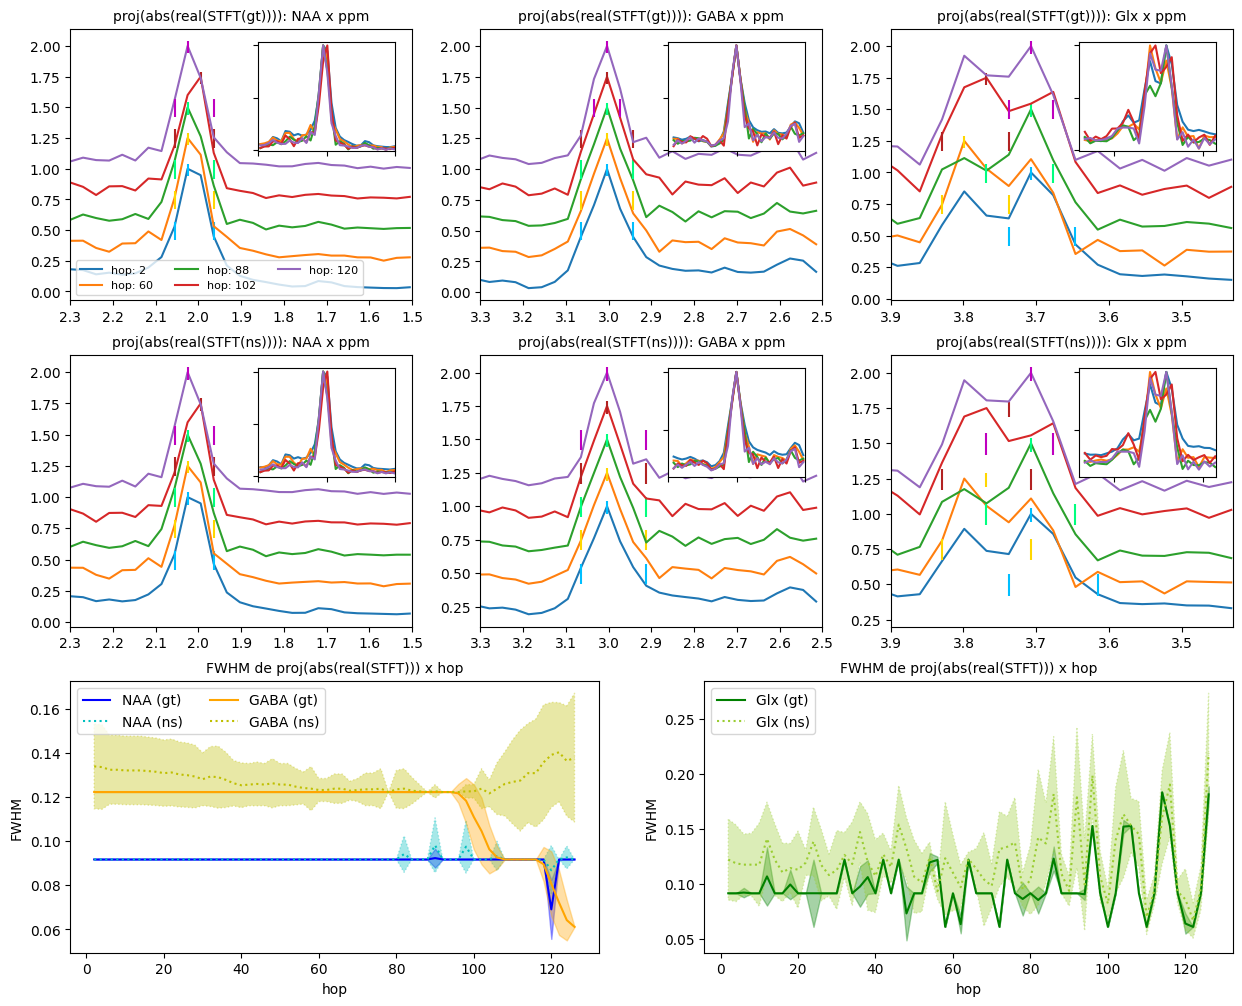

In [18]:
fig = plt.figure(figsize=(15, 12)) 

ax1 = plt.subplot2grid((3, 3), (0, 0))  
ax2 = plt.subplot2grid((3, 3), (0, 1))  
ax3 = plt.subplot2grid((3, 3), (0, 2)) 
ax6 = plt.subplot2grid((3, 3), (1, 0))  
ax7 = plt.subplot2grid((3, 3), (1, 1))  
ax8 = plt.subplot2grid((3, 3), (1, 2)) 

ax4 = plt.subplot2grid((3, 2), (2, 0)) 
ax5 = plt.subplot2grid((3, 2), (2, 1))

axins1 = ax1.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins2 = ax2.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins3 = ax3.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins6 = ax6.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins7 = ax7.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])
axins8 = ax8.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])

#plot_id = np.arange(0,len(hop_),10)
plot_id = [0,29,43,50,59]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
colors_sec = ['deepskyblue','gold','springgreen','firebrick','m']
for i in range(5):
    aux = np.mean((np.sum(np.abs(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0])),axis=2)),axis=0)
    aux_ns = np.mean((np.sum(np.abs(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0])),axis=2)),axis=0)
    aux1d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    ax1.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(aux[aux1d5:aux2d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax6.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(aux_ns[aux1d5:aux2d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax2.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax7.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax3.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax8.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    axins1.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(aux[aux1d5:aux2d5]),color=colors[i])
    axins6.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(aux_ns[aux1d5:aux2d5]),color=colors[i])
    axins2.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5]),color=colors[i])
    axins7.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5]),color=colors[i])
    axins3.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2]),color=colors[i])
    axins8.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2]),color=colors[i])
    aux_NAA = np.mean(idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_gt['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax6.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax7.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_ns['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax8.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])


ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(3.3,2.5)
ax3.set_xlim(3.9,3.43)  
ax1.legend(loc='lower left', ncols=3,fontsize=8)
#ax2.legend(loc='upper left')
#ax3.legend(loc='upper left')
ax1.set_title('proj(abs(real(STFT(gt)))): NAA x ppm',fontsize = 10)
ax2.set_title('proj(abs(real(STFT(gt)))): GABA x ppm',fontsize = 10)
ax3.set_title('proj(abs(real(STFT(gt)))): Glx x ppm',fontsize = 10)

ax6.set_xlim(2.3,1.5) 
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.9,3.43)  
#ax6.legend(loc='upper left')
#ax7.legend(loc='upper left')
#ax8.legend(loc='upper left')
ax6.set_title('proj(abs(real(STFT(ns)))): NAA x ppm',fontsize = 10)
ax7.set_title('proj(abs(real(STFT(ns)))): GABA x ppm',fontsize = 10)
ax8.set_title('proj(abs(real(STFT(ns)))): Glx x ppm',fontsize = 10)


ax4.plot(hop_,gt_metrics['fwhm_hop']['NAA']['mean'],label='NAA (gt)',color='b')
ax4.fill_between(hop_, np.array(gt_metrics['fwhm_hop']['NAA']['mean']) - np.array(gt_metrics['fwhm_hop']['NAA']['std']), 
                        np.array(gt_metrics['fwhm_hop']['NAA']['mean']) + np.array(gt_metrics['fwhm_hop']['NAA']['std']), alpha=0.35, color = 'b')
ax4.plot(hop_,ns_metrics['fwhm_hop']['NAA']['mean'],label='NAA (ns)',color='c',linestyle='dotted')
ax4.fill_between(hop_, np.array(ns_metrics['fwhm_hop']['NAA']['mean']) - np.array(ns_metrics['fwhm_hop']['NAA']['std']), 
                        np.array(ns_metrics['fwhm_hop']['NAA']['mean']) + np.array(ns_metrics['fwhm_hop']['NAA']['std']), alpha=0.35, color = 'c',linestyle='dotted')
ax4.plot(hop_,gt_metrics['fwhm_hop']['GABA']['mean'],label='GABA (gt)',color='orange')
ax4.fill_between(hop_, np.array(gt_metrics['fwhm_hop']['GABA']['mean']) - np.array(gt_metrics['fwhm_hop']['GABA']['std']), 
                        np.array(gt_metrics['fwhm_hop']['GABA']['mean']) + np.array(gt_metrics['fwhm_hop']['GABA']['std']), alpha=0.35, color = 'orange')
ax4.plot(hop_,ns_metrics['fwhm_hop']['GABA']['mean'],label='GABA (ns)',color='y',linestyle='dotted')
ax4.fill_between(hop_, np.array(ns_metrics['fwhm_hop']['GABA']['mean']) - np.array(ns_metrics['fwhm_hop']['GABA']['std']), 
                        np.array(ns_metrics['fwhm_hop']['GABA']['mean']) + np.array(ns_metrics['fwhm_hop']['GABA']['std']), alpha=0.35, color = 'y',linestyle='dotted')
ax4.set_title('FWHM de proj(abs(real(STFT))) x hop',fontsize = 10)
ax4.set_xlabel('hop',fontsize = 10)
ax4.set_ylabel('FWHM',fontsize = 10)
ax4.legend(loc='upper left', ncols = 2)
ax5.plot(hop_,gt_metrics['fwhm_hop']['Glx']['mean'],label='Glx (gt)',color='g')
ax5.fill_between(hop_, np.array(gt_metrics['fwhm_hop']['Glx']['mean']) - np.array(gt_metrics['fwhm_hop']['Glx']['std']), 
                    np.array(gt_metrics['fwhm_hop']['Glx']['mean']) + np.array(gt_metrics['fwhm_hop']['Glx']['std']), alpha=0.35, color = 'g')
ax5.plot(hop_,ns_metrics['fwhm_hop']['Glx']['mean'],label='Glx (ns)',color='yellowgreen',linestyle='dotted')
ax5.fill_between(hop_, np.array(ns_metrics['fwhm_hop']['Glx']['mean']) - np.array(ns_metrics['fwhm_hop']['Glx']['std']), 
                    np.array(ns_metrics['fwhm_hop']['Glx']['mean']) + np.array(ns_metrics['fwhm_hop']['Glx']['std']), alpha=0.35, color = 'yellowgreen',linestyle='dotted')
ax5.set_title('FWHM de proj(abs(real(STFT))) x hop',fontsize = 10)
ax5.set_xlabel('hop',fontsize = 10)
ax5.set_ylabel('FWHM',fontsize = 10)
ax5.legend(loc='upper left')

if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_fwhm_abs.png')

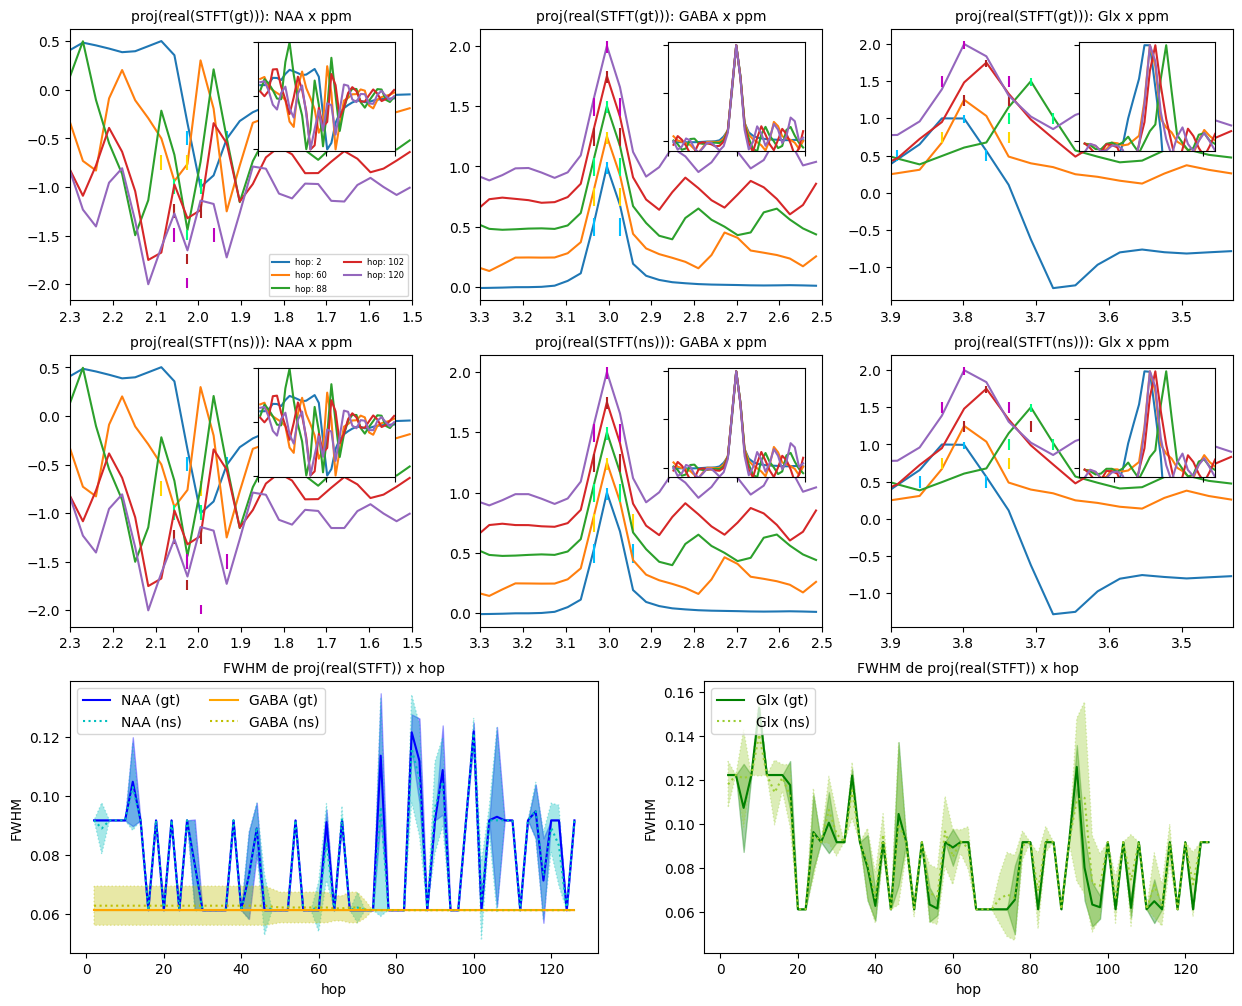

In [27]:
fig = plt.figure(figsize=(15, 12)) 

ax1 = plt.subplot2grid((3, 3), (0, 0))  
ax2 = plt.subplot2grid((3, 3), (0, 1))  
ax3 = plt.subplot2grid((3, 3), (0, 2)) 
ax6 = plt.subplot2grid((3, 3), (1, 0))  
ax7 = plt.subplot2grid((3, 3), (1, 1))  
ax8 = plt.subplot2grid((3, 3), (1, 2)) 

ax4 = plt.subplot2grid((3, 2), (2, 0)) 
ax5 = plt.subplot2grid((3, 2), (2, 1))

axins1 = ax1.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-1.03,1), xticklabels=[], yticklabels=[])
axins2 = ax2.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins3 = ax3.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins6 = ax6.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-1.03,1), xticklabels=[], yticklabels=[])
axins7 = ax7.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins8 = ax8.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])

#plot_id = np.arange(0,len(hop_),10)
plot_id = [0,29,43,50,59]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
colors_sec = ['deepskyblue','gold','springgreen','firebrick','m']
for i in range(5):
    aux = np.mean((np.sum(np.real(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][0]),axis=2)),axis=0)
    aux_ns = np.mean((np.sum(np.real(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][0]),axis=2)),axis=0)
    aux1d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43 = utils.give_idx_ppm_point(ppm_array=spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    ax1.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(np.abs(aux[aux1d5:aux2d5]))-0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax6.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(np.abs(aux_ns[aux1d5:aux2d5]))-0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax2.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax7.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax3.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax8.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    axins1.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(np.abs(aux[aux1d5:aux2d5])),color=colors[i])
    axins6.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(np.abs(aux_ns[aux1d5:aux2d5])),color=colors[i])
    axins2.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5]),color=colors[i])
    axins7.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5]),color=colors[i])
    axins3.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2]),color=colors[i])
    axins8.plot(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2]),color=colors[i])
    aux_NAA = np.mean(idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],-0.94-0.25*i,-1.04-0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_real_gt['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax6.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],-0.94-0.25*i,-1.04-0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax7.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_real_ns['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax8.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_ns['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_gt['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])


ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(3.3,2.5)
ax3.set_xlim(3.9,3.43)  
ax1.legend(loc='lower right', ncols=2,fontsize=6)
#ax2.legend(loc='upper left')
#ax3.legend(loc='upper left')
ax1.set_title('proj(real(STFT(gt))): NAA x ppm',fontsize = 10)
ax2.set_title('proj(real(STFT(gt))): GABA x ppm',fontsize = 10)
ax3.set_title('proj(real(STFT(gt))): Glx x ppm',fontsize = 10)

ax6.set_xlim(2.3,1.5) 
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.9,3.43)  
#ax6.legend(loc='upper left')
#ax7.legend(loc='upper left')
#ax8.legend(loc='upper left')
ax6.set_title('proj(real(STFT(ns))): NAA x ppm',fontsize = 10)
ax7.set_title('proj(real(STFT(ns))): GABA x ppm',fontsize = 10)
ax8.set_title('proj(real(STFT(ns))): Glx x ppm',fontsize = 10)


ax4.plot(hop_,gt_metrics['fwhm_hop_real']['NAA']['mean'],label='NAA (gt)',color='b')
ax4.fill_between(hop_, np.array(gt_metrics['fwhm_hop_real']['NAA']['mean']) - np.array(gt_metrics['fwhm_hop_real']['NAA']['std']), 
                        np.array(gt_metrics['fwhm_hop_real']['NAA']['mean']) + np.array(gt_metrics['fwhm_hop_real']['NAA']['std']), alpha=0.35, color = 'b')
ax4.plot(hop_,ns_metrics['fwhm_hop_real']['NAA']['mean'],label='NAA (ns)',color='c',linestyle='dotted')
ax4.fill_between(hop_, np.array(ns_metrics['fwhm_hop_real']['NAA']['mean']) - np.array(ns_metrics['fwhm_hop_real']['NAA']['std']), 
                        np.array(ns_metrics['fwhm_hop_real']['NAA']['mean']) + np.array(ns_metrics['fwhm_hop_real']['NAA']['std']), alpha=0.35, color = 'c',linestyle='dotted')
ax4.plot(hop_,gt_metrics['fwhm_hop_real']['GABA']['mean'],label='GABA (gt)',color='orange')
ax4.fill_between(hop_, np.array(gt_metrics['fwhm_hop_real']['GABA']['mean']) - np.array(gt_metrics['fwhm_hop_real']['GABA']['std']), 
                        np.array(gt_metrics['fwhm_hop_real']['GABA']['mean']) + np.array(gt_metrics['fwhm_hop_real']['GABA']['std']), alpha=0.35, color = 'orange')
ax4.plot(hop_,ns_metrics['fwhm_hop_real']['GABA']['mean'],label='GABA (ns)',color='y',linestyle='dotted')
ax4.fill_between(hop_, np.array(ns_metrics['fwhm_hop_real']['GABA']['mean']) - np.array(ns_metrics['fwhm_hop_real']['GABA']['std']), 
                        np.array(ns_metrics['fwhm_hop_real']['GABA']['mean']) + np.array(ns_metrics['fwhm_hop_real']['GABA']['std']), alpha=0.35, color = 'y',linestyle='dotted')
ax4.set_title('FWHM de proj(real(STFT)) x hop',fontsize = 10)
ax4.set_xlabel('hop',fontsize = 10)
ax4.set_ylabel('FWHM',fontsize = 10)
ax4.legend(loc='upper left', ncols = 2)
ax5.plot(hop_,gt_metrics['fwhm_hop_real']['Glx']['mean'],label='Glx (gt)',color='g')
ax5.fill_between(hop_, np.array(gt_metrics['fwhm_hop_real']['Glx']['mean']) - np.array(gt_metrics['fwhm_hop_real']['Glx']['std']), 
                    np.array(gt_metrics['fwhm_hop_real']['Glx']['mean']) + np.array(gt_metrics['fwhm_hop_real']['Glx']['std']), alpha=0.35, color = 'g')
ax5.plot(hop_,ns_metrics['fwhm_hop_real']['Glx']['mean'],label='Glx (ns)',color='yellowgreen',linestyle='dotted')
ax5.fill_between(hop_, np.array(ns_metrics['fwhm_hop_real']['Glx']['mean']) - np.array(ns_metrics['fwhm_hop_real']['Glx']['std']), 
                    np.array(ns_metrics['fwhm_hop_real']['Glx']['mean']) + np.array(ns_metrics['fwhm_hop_real']['Glx']['std']), alpha=0.35, color = 'yellowgreen',linestyle='dotted')
ax5.set_title('FWHM de proj(real(STFT)) x hop',fontsize = 10)
ax5.set_xlabel('hop',fontsize = 10)
ax5.set_ylabel('FWHM',fontsize = 10)
ax5.legend(loc='upper left')

if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_and_noisy_fwhm_real.png')

O padrão de listras das imagens muda com hop?

A taxa de cruzamento com zero (ZCR) coincide para espectrogramas gerados de sinais gt e ns. Com o aumento do hop, o número de colunas da imagem muda, desse modo, mesmo que visualmente o pico de GABA seja sempre branco, com um envoltório preto, o ZCR do GABA muda com o hop, ele aumenta pois um cruzamento se torna uma taxa maior a medida que o denominador diminui. Para os picos de NAA e Glx, tanto o numerador quanto o denominador da razão mudam ao mesmo tempo, e o que se observa é que o ZCR do NAA varia de modo que dois máximos estão distantes em média de 14 unidades de hop. Nos dois exemplos mostrados, observa-se como a quantidade de listras diminui e aumenta de novo. Já o comportamento das listras em Glx não é tão bem definido, nota-se que nos exemplos, em ambos a frequência de listras parece diminuir com o hop. O que torna o comportamento das listras de Glx difícil de se compreender é o fato que são dois picos combinados, que não variam no mesmo padrão o com hop.

Finalmente, o perfil dos picos de NAA e Glx ilustram esse mesmo fenômeno visto como um sinal ao longo do tempo.

In [28]:
aux_concat = (np.arange(3,12)).tolist()
spgram_hop_concat_for_zcr_1 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_gt,list_time_idx=idx_time_0d4,fid_idx_plot=0)
aux_concat = (np.arange(11,20)).tolist()
spgram_hop_concat_for_zcr_2 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_gt,list_time_idx=idx_time_0d4,fid_idx_plot=0)

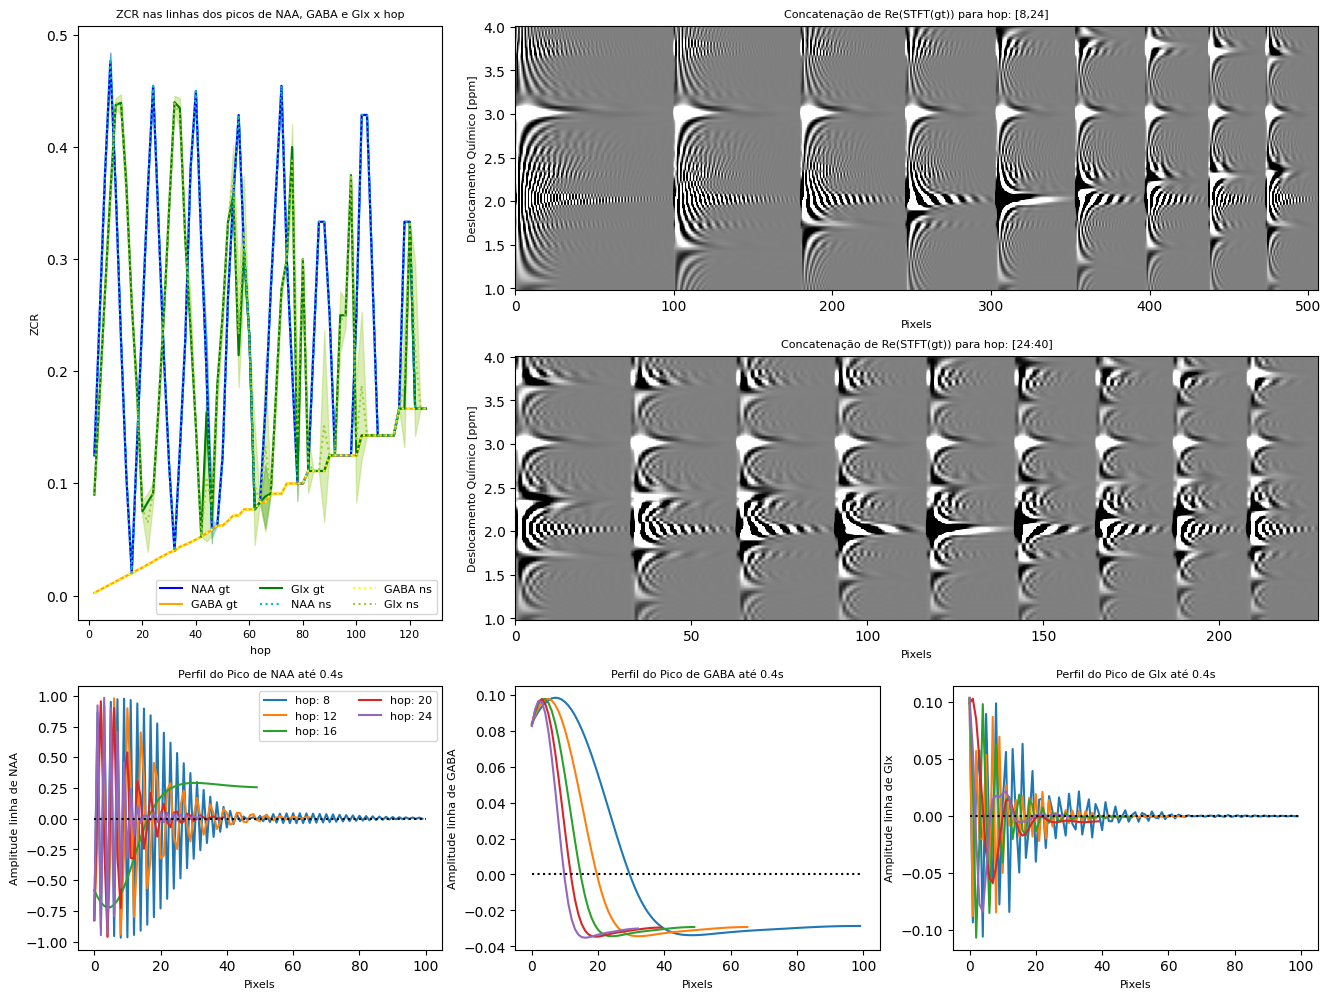

In [60]:
from matplotlib.gridspec import GridSpec
# Create figure and GridSpec
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0:2, 0])  
ax2 = fig.add_subplot(gs[0, 1:]) 
#ax3 = fig.add_subplot(gs[1, 0])  
#ax3.axis('off')
ax4 = fig.add_subplot(gs[1, 1:]) 
ax5 = fig.add_subplot(gs[2, 0])    
ax6 = fig.add_subplot(gs[2, 1]) 
ax7 = fig.add_subplot(gs[2, 2])

ax1.plot(hop_,gt_metrics['zcr_']['NAA']['mean'],color='b',label='NAA gt')
ax1.fill_between(hop_, np.array(gt_metrics['zcr_']['NAA']['mean']) - np.array(gt_metrics['zcr_']['NAA']['std']), 
                        np.array(gt_metrics['zcr_']['NAA']['mean']) + np.array(gt_metrics['zcr_']['NAA']['std']), alpha=0.35, color = 'b')
ax1.plot(hop_,gt_metrics['zcr_']['GABA']['mean'],color='orange',label='GABA gt')
ax1.fill_between(hop_, np.array(gt_metrics['zcr_']['GABA']['mean']) - np.array(gt_metrics['zcr_']['GABA']['std']), 
                        np.array(gt_metrics['zcr_']['GABA']['mean']) + np.array(gt_metrics['zcr_']['GABA']['std']), alpha=0.35, color = 'orange')
ax1.plot(hop_,gt_metrics['zcr_']['Glx']['mean'],color='g',label='Glx gt')
ax1.fill_between(hop_, np.array(gt_metrics['zcr_']['Glx']['mean']) - np.array(gt_metrics['zcr_']['Glx']['std']), 
                        np.array(gt_metrics['zcr_']['Glx']['mean']) + np.array(gt_metrics['zcr_']['Glx']['std']), alpha=0.35, color = 'g')
ax1.plot(hop_,ns_metrics['zcr_']['NAA']['mean'],color='c',label='NAA ns',linestyle='dotted')
ax1.fill_between(hop_, np.array(ns_metrics['zcr_']['NAA']['mean']) - np.array(ns_metrics['zcr_']['NAA']['std']), 
                        np.array(ns_metrics['zcr_']['NAA']['mean']) + np.array(ns_metrics['zcr_']['NAA']['std']), alpha=0.35, color = 'c')
ax1.plot(hop_,ns_metrics['zcr_']['GABA']['mean'],color='yellow',label='GABA ns',linestyle='dotted')
ax1.fill_between(hop_, np.array(ns_metrics['zcr_']['GABA']['mean']) - np.array(ns_metrics['zcr_']['GABA']['std']), 
                        np.array(ns_metrics['zcr_']['GABA']['mean']) + np.array(ns_metrics['zcr_']['GABA']['std']), alpha=0.35, color = 'yellow')
ax1.plot(hop_,ns_metrics['zcr_']['Glx']['mean'],color='yellowgreen',label='Glx ns',linestyle='dotted')
ax1.fill_between(hop_, np.array(ns_metrics['zcr_']['Glx']['mean']) - np.array(ns_metrics['zcr_']['Glx']['std']), 
                        np.array(ns_metrics['zcr_']['Glx']['mean']) + np.array(ns_metrics['zcr_']['Glx']['std']), alpha=0.35, color = 'yellowgreen')
ax1.legend(loc='lower right', ncol=3,fontsize=8)
ax1.set_title('ZCR nas linhas dos picos de NAA, GABA e Glx x hop', fontsize=8)
ax1.set_ylabel('ZCR', fontsize=8)
ax1.set_xlabel('hop', fontsize=8)
ax1.set_xticks([0,20,40,60,80,100,120])
ax1.set_xticklabels(['0','20','40','60','80','100','120'],fontsize=8)


ax2.imshow(np.real(spgram_hop_concat_for_zcr_1[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_for_zcr_1.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
ax2.set_xlabel('Pixels', fontsize=8)
ax2.set_ylabel('Deslocamento Químico [ppm]', fontsize=8)
ax2.set_title('Concatenação de Re(STFT(gt)) para hop: [8,24]', fontsize=8)

ax4.imshow(np.real(spgram_hop_concat_for_zcr_2[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_for_zcr_2.shape[-1],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop_gt['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
ax4.set_xlabel('Pixels', fontsize=8)
ax4.set_ylabel('Deslocamento Químico [ppm]', fontsize=8)
ax4.set_title('Concatenação de Re(STFT(gt)) para hop: [24:40]', fontsize=8)

for i in range(3,12,2):
    ax5.plot(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][0,idx_freq_NAA[i],:idx_time_0d4[i]])-np.mean(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][:,idx_freq_NAA[i],:idx_time_0d4[i]]),axis=1)[0],label='hop: '+str(hop_[i]))
    ax6.plot(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][0,idx_freq_GABA[i],:idx_time_0d4[i]])-np.mean(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][:,idx_freq_GABA[i],:idx_time_0d4[i]]),axis=1)[0],label='hop: '+str(hop_[i]))
    ax7.plot(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][0,idx_freq_Glx[i],:idx_time_0d4[i]])-np.mean(np.real(spgram_hop_gt['hop_'+str(hop_[i])][0][:,idx_freq_Glx[i],:idx_time_0d4[i]]),axis=1)[0],label='hop: '+str(hop_[i]))
ax5.hlines(0,0,100,color='black',linestyle='dotted')
ax6.hlines(0,0,100,color='black',linestyle='dotted')
ax7.hlines(0,0,100,color='black',linestyle='dotted')
ax5.set_title('Perfil do Pico de NAA até 0.4s', fontsize=8)
ax5.set_ylabel('Amplitude linha de NAA', fontsize=8)
ax5.set_xlabel('Pixels', fontsize=8)
ax5.legend(loc='upper right',ncols=2,fontsize=8)
ax6.set_title('Perfil do Pico de GABA até 0.4s', fontsize=8)
ax6.set_ylabel('Amplitude linha de GABA', fontsize=8)
ax6.set_xlabel('Pixels', fontsize=8)
ax7.set_title('Perfil do Pico de Glx até 0.4s', fontsize=8)
ax7.set_ylabel('Amplitude linha de Glx', fontsize=8)
ax7.set_xlabel('Pixels', fontsize=8)
plt.subplots_adjust(hspace=0.25) 

Get some statistical insights:

First, let's divide the image in sections of ppm:

In [23]:
sections = [-4,-3,-2,-1,0,1,1.50,2.50,3.50,4,5,6,7,8.50,9,10]
idx_time_list_sup = []
for i in range(len(hop_)):
    idx_time_list_sup.append([idx_time_0d05[i],idx_time_0d05[i],idx_time_0d05[i],idx_time_0d05[i],idx_time_0d05[i],
                            idx_time_0d4[i],idx_time_0d4[i],idx_time_0d4[i],idx_time_0d4[i],idx_time_0d4[i],
                            idx_time_0d05[i],idx_time_0d05[i],
                            idx_time_0d4[i],idx_time_0d05[i],idx_time_0d05[i]])
max_sec, mean_sec, std_sec = funcstud.get_max_mean_std_per_sections_for_different_spgrams(spgram_dict=spgram_hop, part='real', sections=sections, idx_time_list_sup=idx_time_list_sup)

idx_time_list_inf = []
for i in range(len(hop_)):
    idx_time_list_inf.append([idx_time_0d6[i]])
max_sec_aux, mean_sec_aux, std_sec_aux = funcstud.get_max_mean_std_per_sections_for_different_spgrams(spgram_dict=spgram_hop, part='real', sections=[1,4], idx_time_list_inf=idx_time_list_inf)
max_sec['residual'] = max_sec_aux['1:4']
mean_sec['residual'] = mean_sec_aux['1:4']
std_sec['residual'] = std_sec_aux['1:4']

Observe how the maximum value changes in every region with hop:

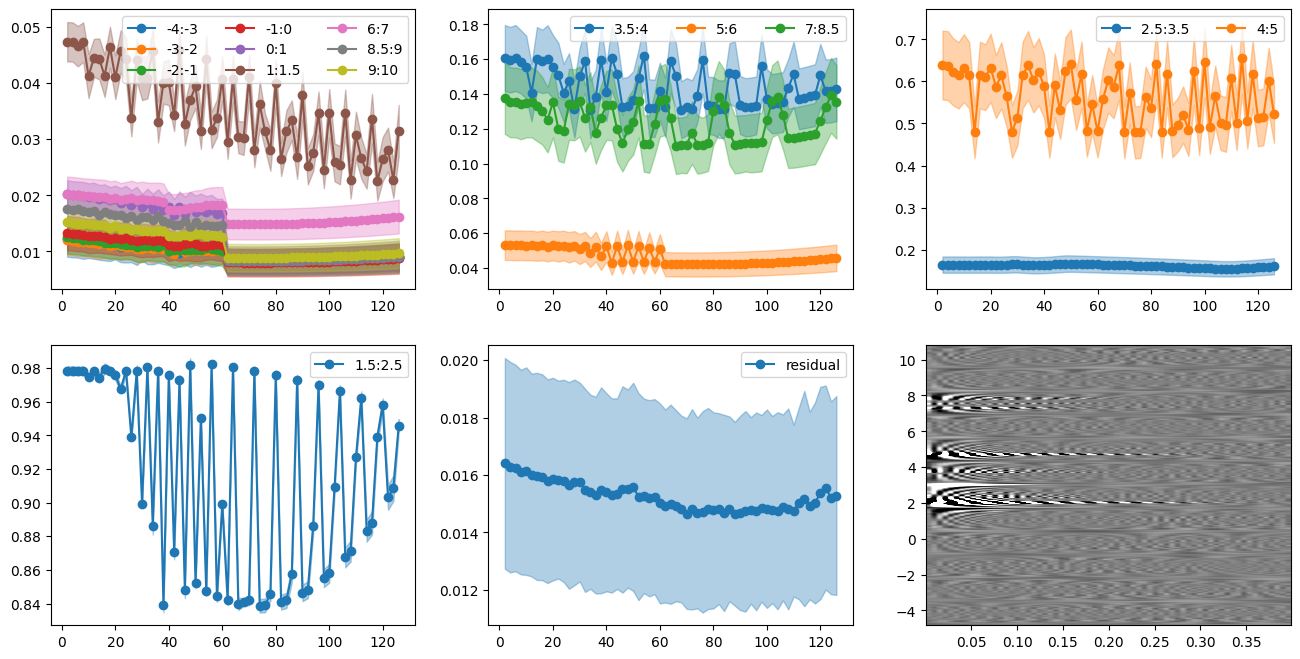

In [24]:
fig,ax = plt.subplots(2,3,figsize=(16,8))
sections = [-4,-3,-2,-1,0,1,1.50,2.50,3.50,4,5,6,7,8.50,9,10]

first_plot = [0,1,2,3,4,5,11,13,14]
second_plot = [8,10,12]
third_plot = [7,9]
fourth_plot = [6]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

for j in range(len(first_plot)):
        aux = max_sec[str(sections[first_plot[j]])+':'+str(sections[first_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[first_plot[j]])+':'+str(sections[first_plot[j]+1])]['std']
        ax.flat[0].plot(hop_,aux,label =str(sections[first_plot[j]])+':'+str(sections[first_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[0].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
for j in range(len(second_plot)):
        aux = max_sec[str(sections[second_plot[j]])+':'+str(sections[second_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[second_plot[j]])+':'+str(sections[second_plot[j]+1])]['std']
        ax.flat[1].plot(hop_,aux,label =str(sections[second_plot[j]])+':'+str(sections[second_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[1].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
for j in range(len(third_plot)):
        aux = max_sec[str(sections[third_plot[j]])+':'+str(sections[third_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[third_plot[j]])+':'+str(sections[third_plot[j]+1])]['std']
        ax.flat[2].plot(hop_,aux,label =str(sections[third_plot[j]])+':'+str(sections[third_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[2].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
for j in range(len(fourth_plot)):
        aux = max_sec[str(sections[fourth_plot[j]])+':'+str(sections[fourth_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[fourth_plot[j]])+':'+str(sections[fourth_plot[j]+1])]['std']
        ax.flat[3].plot(hop_,aux,label =str(sections[fourth_plot[j]])+':'+str(sections[fourth_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[3].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
ax.flat[4].plot(hop_,max_sec['residual']['mean'],label='residual',marker='o')
ax.flat[4].fill_between(hop_, np.array(max_sec['residual']['mean']) - np.array(max_sec['residual']['std']), 
                        np.array(max_sec['residual']['mean']) + np.array(max_sec['residual']['std']), alpha=0.35, color=colors[j])
for i in range(5):
    ax.flat[i].legend(loc='upper right',ncols=3)
    
ax.flat[5].imshow(np.real(spgram_hop['hop_'+str(hop_[5])][0][0,:,:idx_time_0d4[5]]), origin='lower',cmap='gray',aspect='auto',vmin=-0.04,vmax=0.04,
            extent = (spgram_hop['hop_'+str(hop_[5])][-1][0],spgram_hop['hop_'+str(hop_[5])][-1][idx_time_0d4[5]],
                     np.flip(spgram_hop['hop_'+str(hop_[5])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[5])][2])[-1]))

Using these values we can segment the regions of the image:

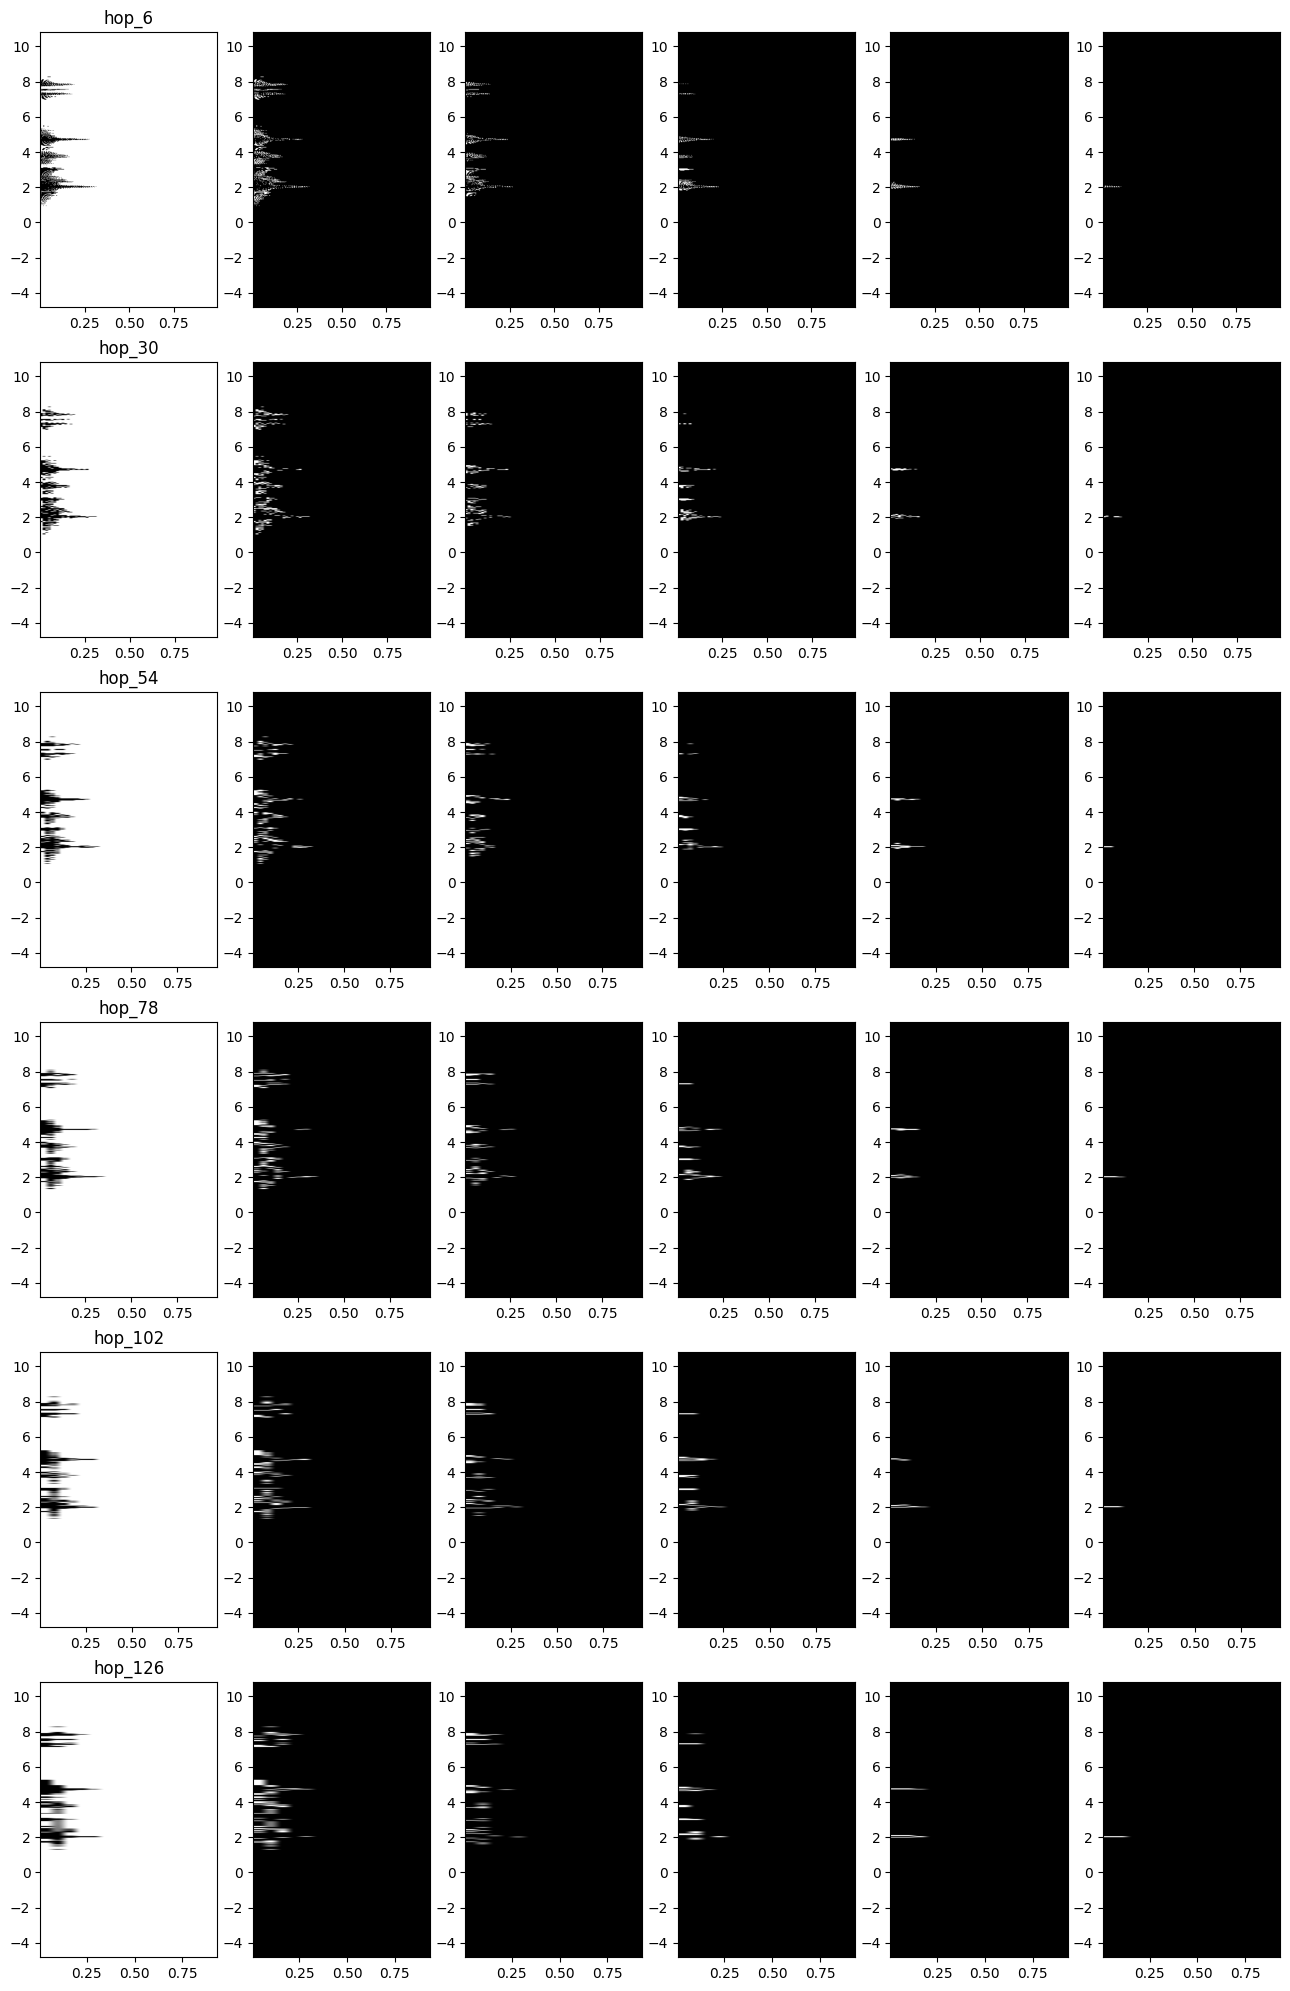

In [31]:
fig,ax = plt.subplots(6,6,figsize=(16,25))
plot_id = np.arange(2,len(hop_),12)
row = 0
for idx in range(len(plot_id)):
    seg_res = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.02
    seg_res2 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.04).astype('int')
    seg_res3 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.04).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.08).astype('int')
    seg_res4 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.2).astype('int')
    seg_res5 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.6).astype('int')
    seg_res6 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.6).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 1).astype('int')
    ax.flat[6*row].imshow(seg_res,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+1].imshow(seg_res2,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+2].imshow(seg_res3,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+3].imshow(seg_res4,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+4].imshow(seg_res5,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+5].imshow(seg_res6,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row].set_title('hop_'+str(hop_[plot_id[idx]]))
    row = row+1

% of pixels in each segmented region x hop value:

In [32]:
regions = [0.02,0.04,0.08,0.2,0.6]
hist, bins, bins_centered, qntty_percent_regions = funcstud.histogram_for_different_spgram_and_qntty_per_histogram_region(spgram_dict=spgram_hop,nbins=5000,part='real',regions=regions,normalized=True)
hist_absolute, bins_absolute, bins_centered_absolute, qntty_absolute_regions = funcstud.histogram_for_different_spgram_and_qntty_per_histogram_region(spgram_dict=spgram_hop,nbins=5000,part='real',regions=regions,normalized=False)

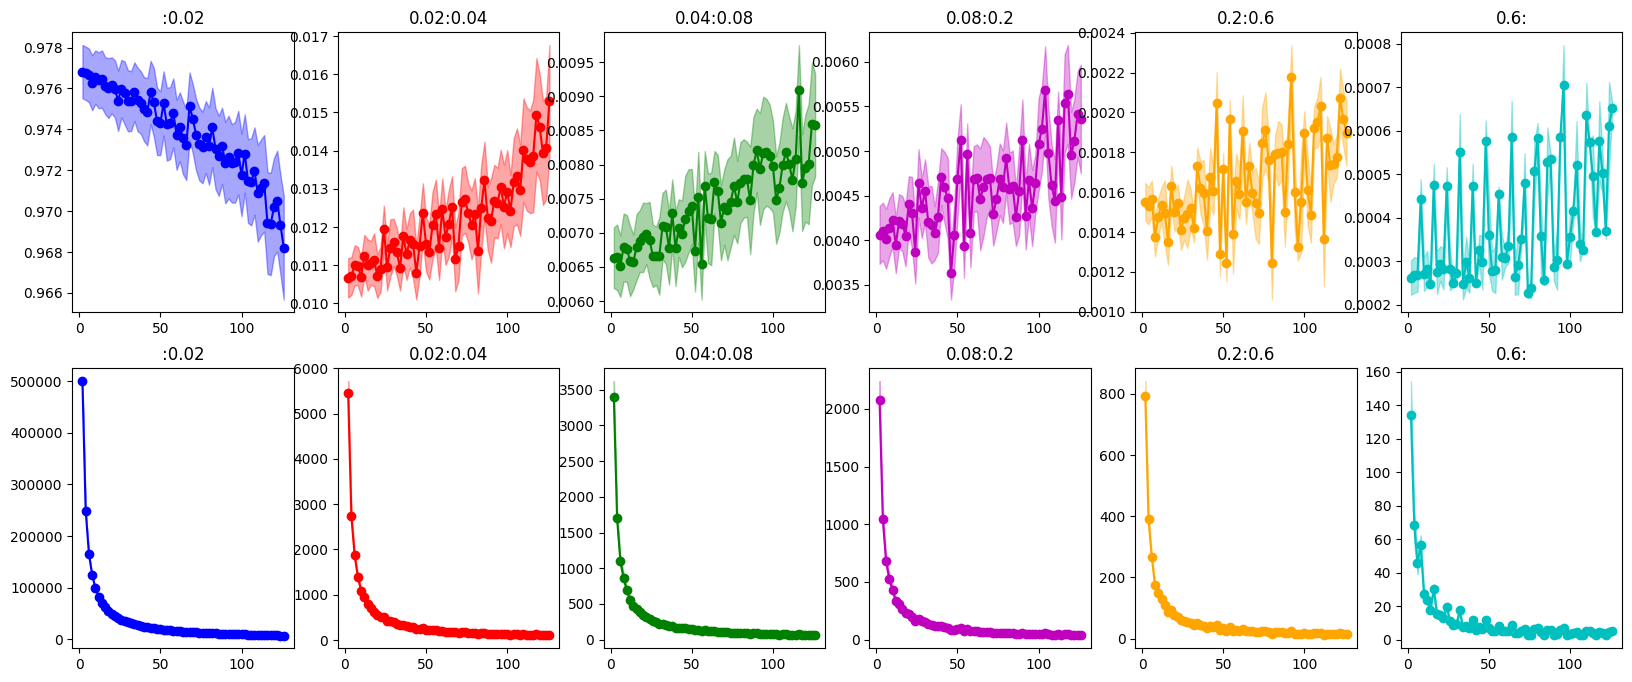

In [33]:
colors = ['b','r','g','m','orange','c']
fig,ax = plt.subplots(2,6,figsize=(20,8))
for i in range(len(list(qntty_percent_regions.keys()))):
    aux = np.array(qntty_percent_regions[list(qntty_percent_regions.keys())[i]]['mean'])
    aux_std = np.array(qntty_percent_regions[list(qntty_percent_regions.keys())[i]]['std'])

    aux_absolute = np.array(qntty_absolute_regions[list(qntty_absolute_regions.keys())[i]]['mean'])
    aux_absolute_std = np.array(qntty_absolute_regions[list(qntty_absolute_regions.keys())[i]]['std'])
    ax[0,i].plot(hop_,aux,marker='o',color=colors[i])
    ax[0,i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    ax[0,i].set_title(list(qntty_percent_regions.keys())[i])
    ax[1,i].plot(hop_,aux_absolute,marker='o',color=colors[i])
    ax[1,i].fill_between(hop_, aux_absolute - aux_absolute_std, 
                       aux_absolute + aux_absolute_std, alpha=0.35, color = colors[i])
    ax[1,i].set_title(list(qntty_absolute_regions.keys())[i])

Stats of each segmented region x hop:

In [10]:
stats_per_region = funcstud.stats_per_segmented_regions_for_different_spgrams(regions_threshold=regions,spgram_dict=spgram_hop, part='real')

In [11]:
stats_global = utils.stats_global_for_different_spgrams(spgram_dict=spgram_hop, part='part')

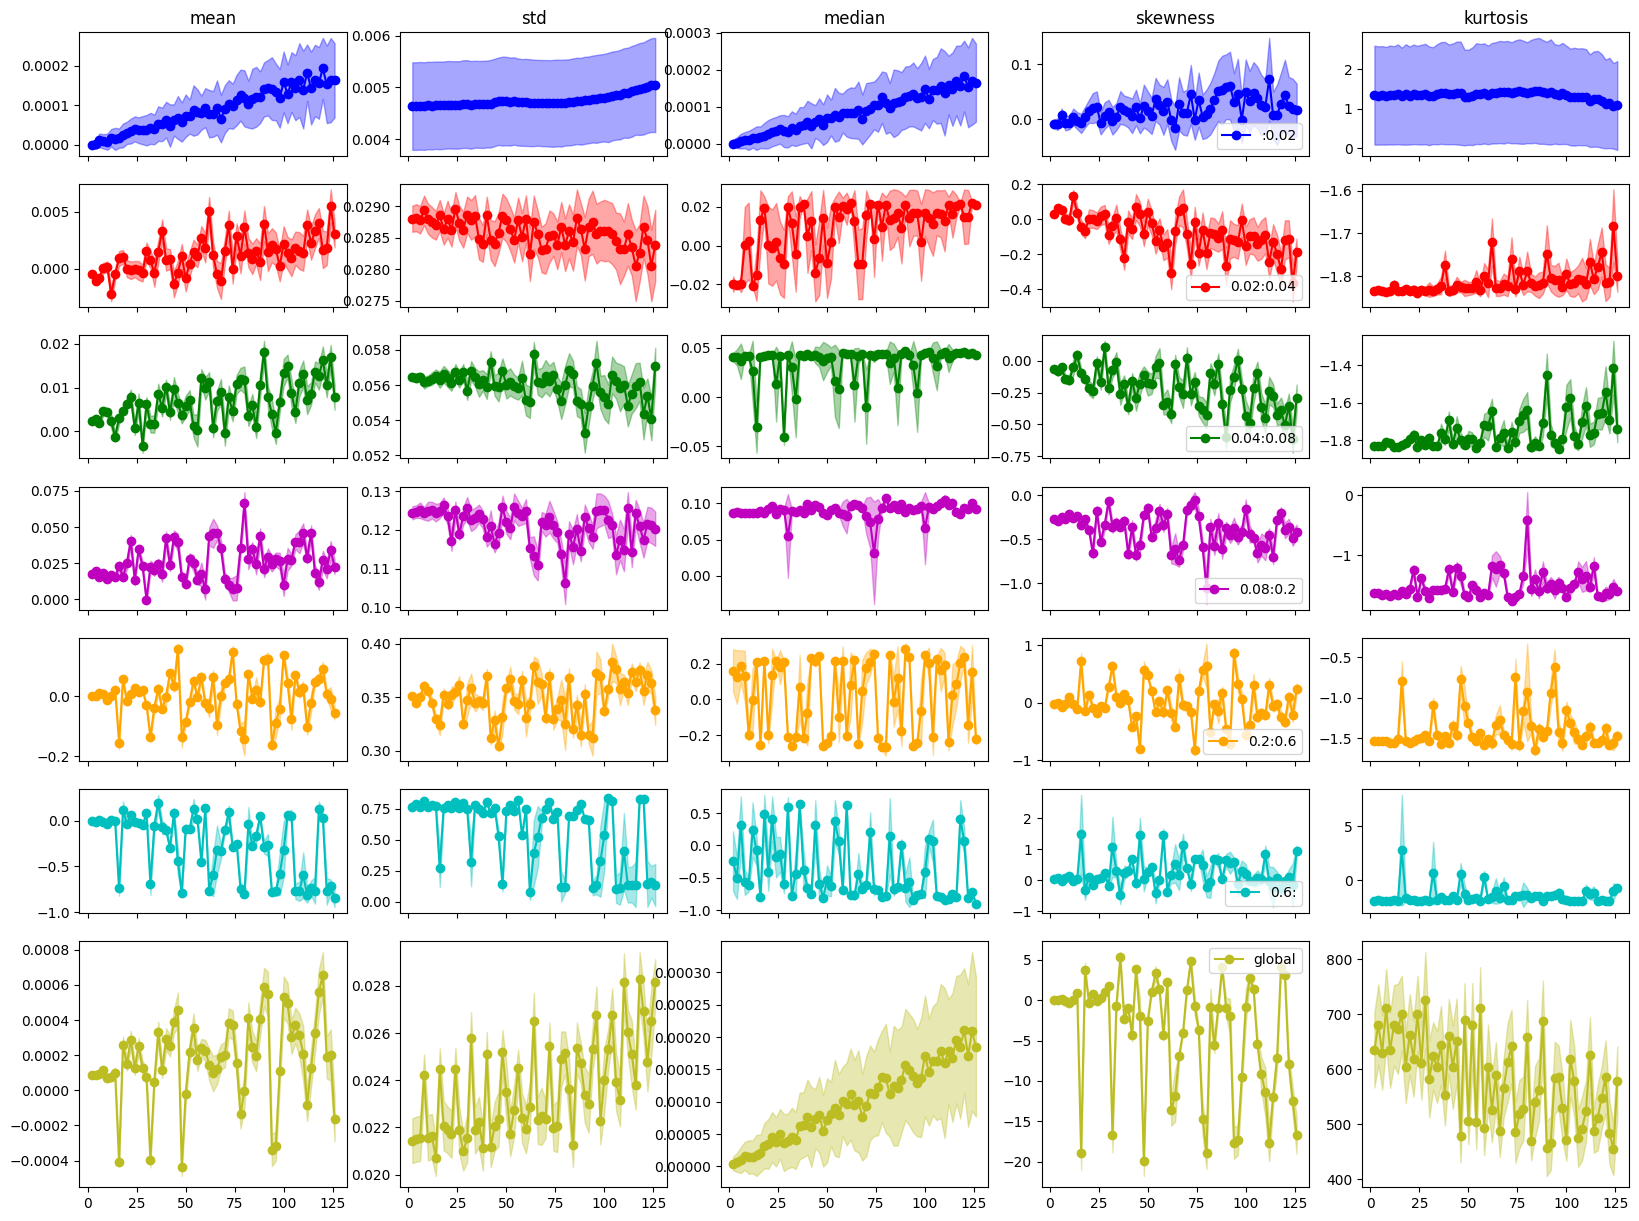

In [12]:
fig,ax = plt.subplots(7,5,figsize=(20,15), sharex='col', height_ratios=[1, 1, 1, 1, 1, 1, 2])

stat_name = ['mean','std','median','skewness','kurtosis']
colors = ['b','r','g','m','orange','c']
for j in range(len(stat_name)):
    for i in range(len(list(stats_per_region[stat_name[j]].keys()))):
        aux = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['mean'])
        aux_std = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['std'])
        ax[i,j].plot(hop_,aux,marker='o',color=colors[i],label=list(stats_per_region[stat_name[j]].keys())[i])
        ax[i,j].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        if i == 0:
            ax[i,j].set_title(stat_name[j])
        if j == 3:
            ax[i,j].legend(loc='lower right')
colors = ['#bcbd22']
for i in range(len(stat_name)):
    aux = np.array(stats_global[stat_name[i]]['mean'])
    aux_std = np.array(stats_global[stat_name[i]]['std'])
    ax[6,i].plot(hop_,aux,marker='o',color=colors[0],label="global")
    ax[6,i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[0])
    if i == 3:
        ax[6,i].legend(loc='upper right')
plt.show()

Checking visually the metrics obtained:

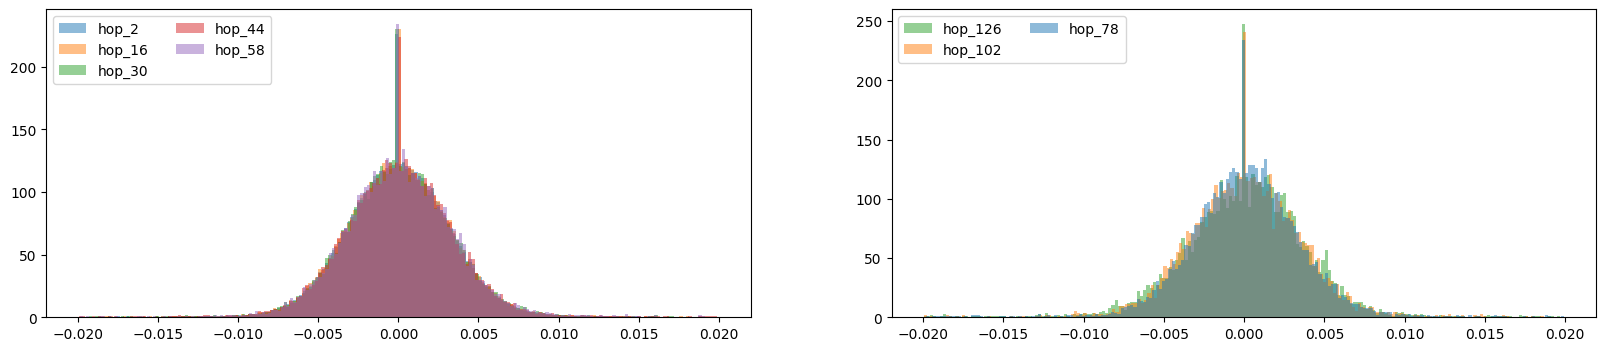

In [13]:
fig,ax = plt.subplots(1,2,figsize=(20,4))
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plot_id = np.arange(0,34,7)
for i in (range(len(plot_id))):
    seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.02
    aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    ax[0].hist(aux,200,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[0].legend(loc='upper left',ncols=2)

plot_id = [38,50,-1]
for i in reversed(range(len(plot_id))):
    seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.02
    aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    ax[1].hist(aux,200,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[1].legend(loc='upper left',ncols=2)

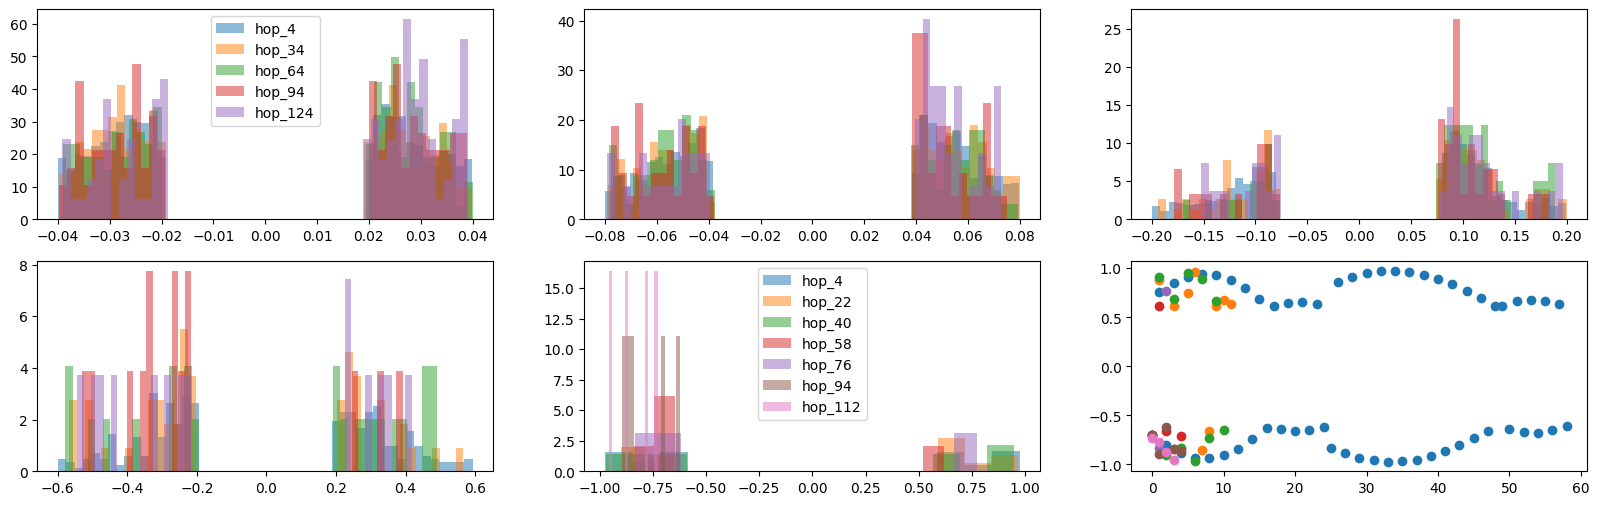

In [69]:
fig,ax = plt.subplots(2,3,figsize=(20,6))
plot_id = np.arange(1,len(hop_),15)
for i in (range(len(plot_id))):
    seg_2 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.04).astype('int')
    aux = np.real(seg_2*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[0].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    seg_3 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.04).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.08).astype('int')
    aux = np.real(seg_3*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[1].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    seg_4 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.2).astype('int')
    aux = np.real(seg_4*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[2].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    seg_5 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.6).astype('int')
    aux = np.real(seg_5*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[3].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    

plot_id = np.arange(1,len(hop_),9)
for i in (range(len(plot_id))):
    seg_6 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.6).astype('int')
    aux = np.real(seg_6*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[4].hist(aux_no_zeros,15,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    ax.flat[5].scatter(np.arange(aux_no_zeros.shape[0]),aux_no_zeros,marker='o')

ax.flat[0].legend(loc='upper center')
ax.flat[4].legend(loc='upper center')

In [16]:
from scipy import stats
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (kurt/std) for region ",reg,":",stats.pearsonr(stats_per_region['std'][reg]['mean'], stats_per_region['kurtosis'][reg]['mean']))

test hypothesis (kurt/std) for region  :0.02 : PearsonRResult(statistic=-0.7809761784358411, pvalue=4.371297980073226e-14)
test hypothesis (kurt/std) for region  0.02:0.04 : PearsonRResult(statistic=-0.6949126432053078, pvalue=2.644818148648319e-10)
test hypothesis (kurt/std) for region  0.04:0.08 : PearsonRResult(statistic=-0.7336946068214941, pvalue=7.92507286758566e-12)
test hypothesis (kurt/std) for region  0.08:0.2 : PearsonRResult(statistic=-0.8221107767199223, pvalue=1.4669394717950702e-16)
test hypothesis (kurt/std) for region  0.2:0.6 : PearsonRResult(statistic=-0.48246634932010074, pvalue=6.220293340268869e-05)
test hypothesis (kurt/std) for region  0.6: : PearsonRResult(statistic=-0.345177415823851, pvalue=0.0055951797995437424)


In [17]:
from scipy import stats
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (skew/mean) for region ",reg,":",stats.pearsonr(stats_per_region['mean'][reg]['mean'], stats_per_region['skewness'][reg]['mean']))

test hypothesis (skew/mean) for region  :0.02 : PearsonRResult(statistic=0.6622543848514901, pvalue=3.398613953696157e-09)
test hypothesis (skew/mean) for region  0.02:0.04 : PearsonRResult(statistic=-0.9883226823675461, pvalue=1.4799486452000583e-51)
test hypothesis (skew/mean) for region  0.04:0.08 : PearsonRResult(statistic=-0.9886564537373446, pvalue=6.140497898265586e-52)
test hypothesis (skew/mean) for region  0.08:0.2 : PearsonRResult(statistic=-0.9763732150736196, pvalue=2.6939333846962635e-42)
test hypothesis (skew/mean) for region  0.2:0.6 : PearsonRResult(statistic=-0.9544189211036425, pvalue=9.909540682535749e-34)
test hypothesis (skew/mean) for region  0.6: : PearsonRResult(statistic=-0.383198346320572, pvalue=0.0019358999409541642)


In [71]:
plot_id = np.arange(len(hop_))
for i in (range(len(plot_id))):
    seg_3 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.04).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.08).astype('int')
    aux = np.real(seg_3*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    hist_aux,bins_aux = np.histogram(aux_no_zeros,50,density = True)
    idx = []
    for k in range(len(hist_aux)):
        if hist_aux[k] == 0:
            idx.append(k)
    print(np.sum(hist_aux[:idx[0]]),np.sum(hist_aux[idx[-1]+1:]))

146.0512106733166 166.59631538173497
145.04256996522997 167.6240479238886
148.60892871291367 164.16487448018975
145.82400760305302 166.9641743857441
140.04702126685675 173.49108604700166
142.90527214857306 169.86853104453027
158.21870218492901 154.50464814302924
147.64993935285008 165.78238804530537
144.24283776473095 168.5955246600752
137.50160902131182 179.80979641248464
131.60495767565598 182.72423875628272
155.1047343114585 157.73362811334766
132.80681334403997 180.8433202982672
44.99674907455824 148.48927194604212
135.99763550262736 182.4358525035246
154.0574913017336 160.6836199598727
147.15499870006732 167.92982204595918
120.77936777160235 192.0589946532037
137.62982832663295 177.22197072196565
128.93943167828752 188.96296021817983
146.43456950868267 170.1225145762637
127.26635000214526 190.89952500321783
139.62278412670497 181.26466711186256
154.87581452381843 162.75085594028366
141.2396320934993 178.40795632863077
17.809917178230535 178.09917178230572
105.54771770760274 155.54

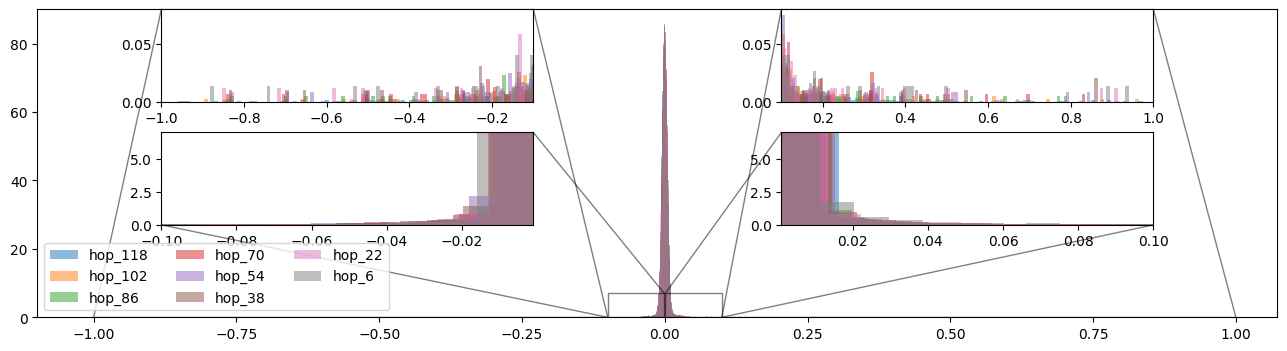

In [64]:
plot_id = np.arange(2,len(hop_),8)
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

fig,ax = plt.subplots(1,1,figsize=(16,4))
for i in reversed(range(len(plot_id))):
    plt.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(),1000,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))



axins = ax.inset_axes([0.1, 0.7, 0.3, 0.3], xlim=(-1, -0.1), ylim=(0, 0.08))
ax.indicate_inset_zoom(axins, edgecolor="black")

# Create the second inset (-0.1, -0.001)
axins2 = ax.inset_axes([0.1, 0.3, 0.3, 0.3], xlim=(-0.1, -0.001), ylim=(0, 7))
ax.indicate_inset_zoom(axins2, edgecolor="black")

# Create the third inset (0.001, 0.1)
axins3 = ax.inset_axes([0.6, 0.3, 0.3, 0.3], xlim=(0.001, 0.1), ylim=(0, 7))
ax.indicate_inset_zoom(axins3, edgecolor="black")

# Create the fourth inset (0.1, 1)
axins4 = ax.inset_axes([0.6, 0.7, 0.3, 0.3], xlim=(0.1, 1), ylim=(0, 0.08))
ax.indicate_inset_zoom(axins4, edgecolor="black")


for i in (range(len(plot_id))):
        axins.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
        axins2.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200,alpha=0.5,density=True,color=colors[i])
        axins3.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
        axins4.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
plt.legend(loc='lower left', ncols=3)

In [18]:
print('mean')
for reg in list(stats_per_region['mean'].keys()):
    print("test hypothesis (mean) global and ",reg,":",stats.pearsonr(stats_per_region['mean'][reg]['mean'], stats_global['mean']['mean']))
print('std')
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (std) global and ",reg,":",stats.pearsonr(stats_per_region['std'][reg]['mean'], stats_global['std']['mean']))

mean
test hypothesis (mean) global and  :0.02 : PearsonRResult(statistic=0.284156391684105, pvalue=0.024007940813225506)
test hypothesis (mean) global and  0.02:0.04 : PearsonRResult(statistic=0.10072084741052842, pvalue=0.4321965766601945)
test hypothesis (mean) global and  0.04:0.08 : PearsonRResult(statistic=0.4628325226894439, pvalue=0.00013378523602827855)
test hypothesis (mean) global and  0.08:0.2 : PearsonRResult(statistic=0.0524475286921305, pvalue=0.6831016324242807)
test hypothesis (mean) global and  0.2:0.6 : PearsonRResult(statistic=0.8337086860134945, pvalue=2.247000073378637e-17)
test hypothesis (mean) global and  0.6: : PearsonRResult(statistic=0.47427604827798453, pvalue=8.61019805503512e-05)
std
test hypothesis (std) global and  :0.02 : PearsonRResult(statistic=0.649747519765119, pvalue=8.329635226889146e-09)
test hypothesis (std) global and  0.02:0.04 : PearsonRResult(statistic=-0.1674655294089297, pvalue=0.18955881530732566)
test hypothesis (std) global and  0.04:0.

In [66]:
stats.pearsonr(stats_global['std']['mean'], stats_global['kurtosis']['mean'])

PearsonRResult(statistic=-0.10067135594131855, pvalue=0.43242397416084655)

In [67]:
stats.pearsonr(stats_global['mean']['mean'], stats_global['skewness']['mean'])

PearsonRResult(statistic=0.7044037135373585, pvalue=1.1808820394949186e-10)

In [74]:
if test_not_save == False:
    zcr_list = {}
    zcr_list['NAA'] = {}
    zcr_list['NAA']['mean'] = list(zcr_['NAA']['mean'])
    zcr_list['NAA']['std'] = list(zcr_['NAA']['std'])
    zcr_list['GABA'] = {}
    zcr_list['GABA']['mean'] = list(zcr_['GABA']['mean'])
    zcr_list['GABA']['std'] = list(zcr_['GABA']['std'])
    zcr_list['Glx'] = {}
    zcr_list['Glx']['mean'] = list(zcr_['Glx']['mean'])
    zcr_list['Glx']['std'] = list(zcr_['Glx']['std'])
    with open("quantitative_metrics_with_noise_hop_variation_mfft_512.txt", "w") as f:
        f.write("fwhm_hop=")
        f.write(json.dumps(fwhm_hop))
        f.write('\n')
        f.write("fwhm_hop_real=")
        f.write(json.dumps(fwhm_hop_real))
        f.write('\n')
        f.write("zcr_=")
        f.write(json.dumps(zcr_list))
        f.write('\n')
        f.write("max_sec=")
        f.write(json.dumps(max_sec))
        f.write('\n')
        f.write("qntty_percent_regions=")
        f.write(json.dumps(qntty_percent_regions))
        f.write('\n')
        f.write("qntty_absolute_regions=")
        f.write(json.dumps(qntty_absolute_regions))
        f.write('\n')
        f.write("stats_per_region=")
        f.write(json.dumps(stats_per_region))
        f.write('\n')
        f.write("stats_global=")
        f.write(json.dumps(stats_global))